In [2]:
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "b1d7f7f8-743f-458e-b3a0-3e09734d716d",
    resource_group = "aq-hackathons",
    name = "aq-hackathon-01",
    location = "eastus"
)


In [3]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

In [4]:
import numpy as np

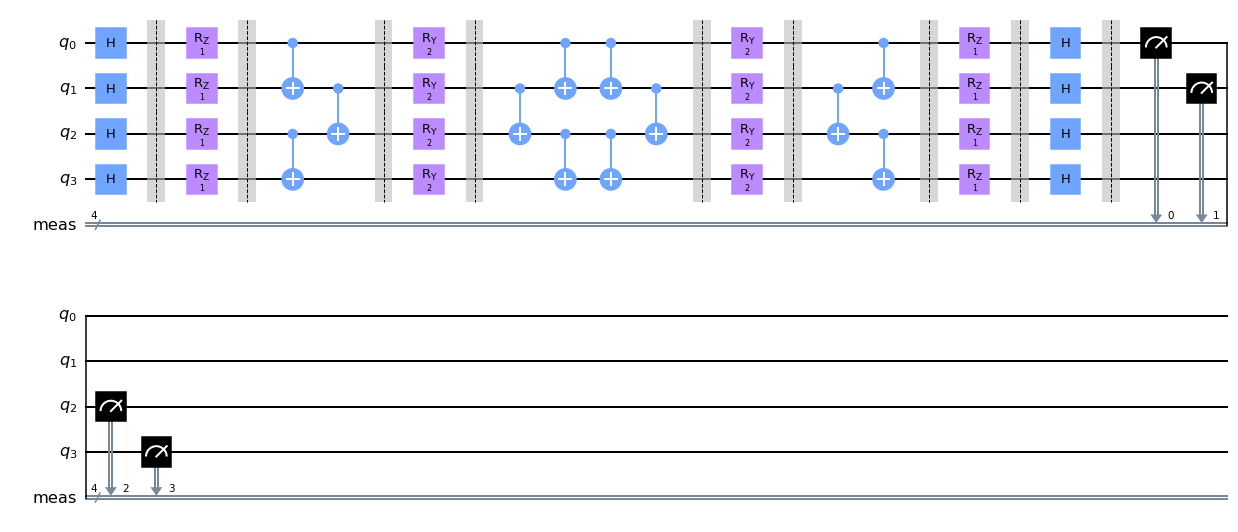

In [5]:
n_qubits = 4
circuit = QuantumCircuit(n_qubits)

for i in range(n_qubits):
    circuit.h(i)
circuit.barrier()

for i in range(n_qubits):
    circuit.rz(phi=1, qubit=i)
circuit.barrier()

circuit.cx(0, 1)
circuit.cx(2,3)
circuit.cx(1,2)

circuit.barrier()

for i in range(n_qubits):
    circuit.ry(theta=2, qubit=i)

circuit.barrier()

circuit.cx(1,2)
circuit.cx(0, 1)
circuit.cx(2,3)
circuit.cx(0, 1)
circuit.cx(2,3)
circuit.cx(1,2)

circuit.barrier()

for i in range(n_qubits):
    circuit.ry(theta=2, qubit=i)
circuit.barrier()

circuit.cx(1,2)
circuit.cx(0, 1)
circuit.cx(2,3)

circuit.barrier()
for i in range(n_qubits):
    circuit.rz(phi=1, qubit=i)
circuit.barrier()
for i in range(n_qubits):
    circuit.h(i)
circuit.measure_all()
# Print out the circuit
circuit.draw(output='mpl')

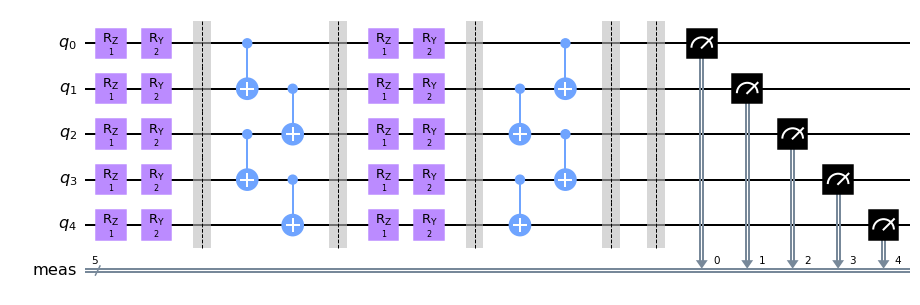

In [6]:
n_qubits = 5

circuit = QuantumCircuit(n_qubits)
cycles  = 1
phi_val   = 1
theta_val = 2


for cycle in range(cycles):
	for i in range(n_qubits):
	    circuit.rz(phi=phi_val, qubit=i)
	
	for j in range(n_qubits):
	    circuit.ry(theta=theta_val, qubit=j)
	
	circuit.barrier()
	
	for i in np.arange(1,n_qubits,2):
	    circuit.cx(control_qubit=i-1, target_qubit=i)
	
	for j in np.arange(2,n_qubits,2):
	    circuit.cx(control_qubit=j-1, target_qubit=j)
	
	circuit.barrier()
	
	for i in range(n_qubits):
	    circuit.rz(phi=phi_val, qubit=i)
	
	for j in range(n_qubits):
	    circuit.ry(theta=theta_val, qubit=j)
	
	circuit.barrier()
	for j in np.arange(2,n_qubits,2):
	    circuit.cx(control_qubit=j-1, target_qubit=j)
	
	for i in np.arange(1,n_qubits,2):
	    circuit.cx(control_qubit=i-1, target_qubit=i)
    
	circuit.barrier()

circuit.measure_all()
circuit.draw(output='mpl')

In [7]:
def qfl_constructor(n_qubits, rot_array1, rot_array2, repetitions):
    circuit1, circuit2 = QuantumCircuit(n_qubits), QuantumCircuit(n_qubits)
    for i in range(n_qubits):
	    circuit1.rz(phi=rot_array1[0][0], qubit=i)
	    circuit2.rz(phi=rot_array2[0][0], qubit=i)

    for j in range(n_qubits):
	    circuit1.ry(theta=rot_array1[0][0], qubit=j)
	    circuit2.ry(theta=rot_array2[0][0], qubit=j)

    circuit.barrier()
	
    for i in np.arange(1,n_qubits,2):
        circuit1.cx(control_qubit=i-1, target_qubit=i)
        circuit2.cx(control_qubit=i-1, target_qubit=i)

    for j in np.arange(2,n_qubits,2):
        circuit1.cx(control_qubit=j-1, target_qubit=j)
        circuit2.cx(control_qubit=j-1, target_qubit=j)

    composed_circuit = circuit1.compose(circuit2.inverse())
    composed_circuit.measure_all()

    return composed_circuit


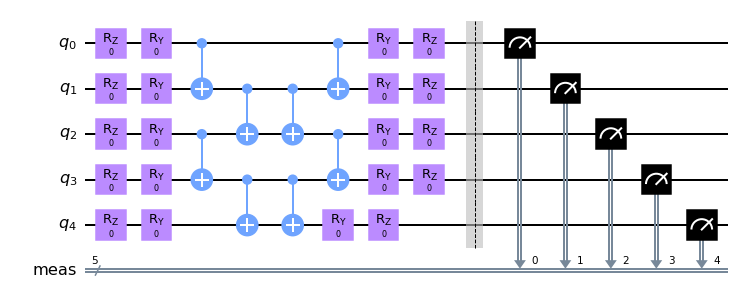

In [8]:
r_arr  = [[0,2,3], [1, 3, 5], [1, 2, 9]] 
circ   = qfl_constructor(5, r_arr, r_arr, 1)

circ.draw(output="mpl")

In [9]:
# trial to build ansatz and do inner product 
# the rotation array has Rz,Ry alternating for each qubit
# arranged qubit by qubit so it as an array of arrays 
# with inner array length of 2*repetitions and outer array of length n_qubits

def qfl_constructor(rot_array):
    n_qubits = len(rot_array)
    repetitions = int(len(rot_array[0])/2)
    circuit = QuantumCircuit(n_qubits,n_qubits)
    # we will have two angles per repetition per qubit
    for j in np.arange(0,2*repetitions,2):
        for i in range(n_qubits):
            circuit.rz(phi=rot_array[i][j], qubit=i)    
    
        for i in range(n_qubits):
            circuit.ry(theta=rot_array[i][j+1], qubit=i)

        circuit.barrier()
    
        for i in np.arange(1,n_qubits,2):
        	circuit.cx(control_qubit=i-1, target_qubit=i)
    
        for i in np.arange(2,n_qubits,2):
        	circuit.cx(control_qubit=i-1, target_qubit=i)
    

    return circuit


def qfl_combined_constructor(rot_array_first, rot_array_second):
    circuit_first = qfl_constructor(rot_array_first)
    circuit_second = qfl_constructor(rot_array_second)
    inverse_circuit_second = circuit_second.inverse()
    circuit_combined = circuit_first.compose(inverse_circuit_second)
    # measure all the qubits at the end to get probability of getting 0000...00 
    circuit_combined.measure_all()
    return circuit_combined

In [10]:
circuit = qfl_combined_constructor(r_arr, r_arr)

In [11]:
provider = AzureQuantumProvider(
  resource_id="/subscriptions/b1d7f7f8-743f-458e-b3a0-3e09734d716d/resourceGroups/aq-hackathons/providers/Microsoft.Quantum/Workspaces/aq-hackathon-01",
  location="eastus"
)

In [12]:
print([backend.name() for backend in provider.backends()])


['ionq.qpu', 'ionq.simulator']


In [13]:
simulator_backend = provider.get_backend("ionq.simulator")


In [14]:
job = simulator_backend.run(circuit, shots=100)
job_id = job.id()
print("Job id", job_id)

Job id 483cb27e-8176-11ec-9f66-00155d146923


In [15]:
job_monitor(job)


Job Status: job has successfully run


In [17]:
result = job.result()


JSONDecodeError: Expecting value: line 1 column 2 (char 1)

In [ ]:
print(result)


In [ ]:
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts)

In [21]:
backend = provider.get_backend("ionq.qpu")
cost = backend.estimate_cost(circuit, shots=100)

print(f"Estimated cost: {cost.estimated_total}")

AttributeError: 'IonQQPUBackend' object has no attribute 'estimate_cost'

In [20]:
qpu_backend = provider.get_backend("ionq.qpu")


In [22]:
qpu_job = qpu_backend.run(circuit, shots=1024)
job_id = qpu_job.id()
print("Job id", job_id)

# Monitor job progress and wait until complete:
job_monitor(qpu_job)

# Get the job results (this method also waits for the Job to complete):
result = qpu_job.result()
print(result)
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts)

Job id 9dc5a2a4-8177-11ec-9f66-00155d146923
Job Status: job is queued (None)

KeyboardInterrupt: 